# Working With HIRES Data
by Yannick Lecoeuche

## Introduction
[This tutorial is written using Python 3. If you are using Python 2, the only changes that should be necessary are putting parentheses around print statements in the cells. Enjoy!]

In this tutorial we will show you how to open HIRES data, display images, and graph one-dimensional spectrums of the information kept in the image. We have supplied three stellar spectra and three corresponding wavelength solutions with this notebook, and we will begin by determining the minimum and maximum wavelengths represented in the spectrum and then attempting to recreate some sample graphs of the spectrum.

First, we must import the necessary programming components:

In [91]:
%matplotlib inline
import numpy as np
from astropy.io import fits as pf
import matplotlib
from matplotlib import pyplot as plt
import lmfit
from lmfit import minimize, Parameters, report_fit, fit_report
from IPython.display import Image

Among these imports includes the fits program, which allows us to easily read HIRES files in the format given, and pyplot, so we can represent the data given in our spectra. The ".fits" files we are working with contain a lot of information, and the fits program allows us to easily access the parts of that information we need. For instance, we will use the fits program to access our spectra (rj122.97.fits), and then dislay image information coded in the fits file:

In [92]:
spectrum_r = pf.open('rj122.97.fits')
spectrum_r.info()

Filename: rj122.97.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     722   (4021, 16)   float32   


The "r" in our file name is because the spectrum we opened only covers one third of the total wavelength range. The other two spectrums we call will have similar tags after them. 

From the information we can see that this file contains a single image of type "PrimaryHDU". This is what we wanted to see, however, a problem becomes apparent upon further inspection. If you look in the "Dimensions" section, you may notice that the axes differ by a large factor. Attempting to plot an image with the x dimension so much larger than the y dimension gives an result like this:

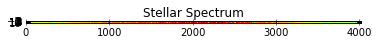

In [93]:
image_r = spectrum_r[0].data
plt.imshow(image_r)
plt.title('Stellar Spectrum')

As you can see, using the .data function gives us just the parts of the file that make up the image itself. Notice that we added the familiar "r" tag to the image variable as well.

The difference between the axes is indeed too large. We can't get much visual information from what appears to be a one dimensional line. To remedy this problem, we can add "aspect = 'auto'" as an argument in our plot function. This simply adjusts the output of the plot function so that the axes are sized similarly.

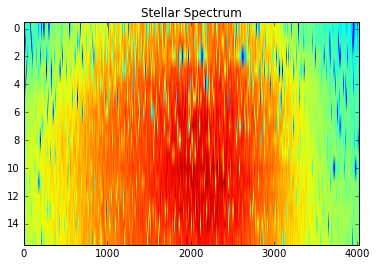

In [94]:
image_r = spectrum_r[0].data
plt.imshow(image_r, aspect = 'auto')
plt.title('Stellar Spectrum')

Much better! This is an image that may look more familiar to you. If not, what we're looking at are the brightness levels of our star at different wavelengths. The information is encoded so that it appears 2-dimensional, but really each horizontal line going down the graph represents the next set of wavelength values. This will make more sense as we start analyzing the information. For now, it would be good to know that each pixel in the image represents a wavelength, with the lowest wavelength in the top left corner and the highest in the bottom right.

Now that we have our spectrum, we can analyze the information inside it most easily by turning parts of it into 1D brightness/wavelength graphs. In order to get our 1D graph from this 2D image, we need to select a single pixel line from the 16 avaliable in the y-axis (remember, we know that the dimensions are 16 by 4021 from looking at the file info). Let's plot line ten in the spectrum:

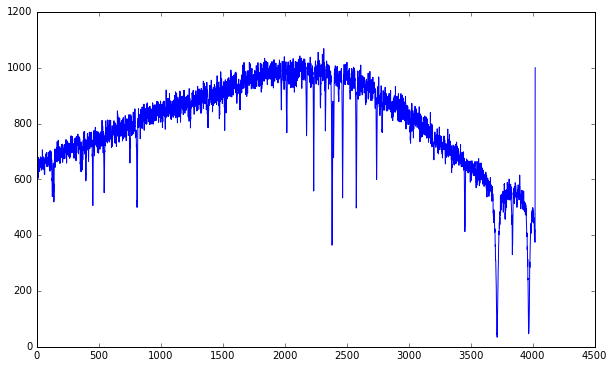

In [95]:
plt.figure(figsize = (10, 6))
plt.plot(image_r[10])

Terrific! There are some clearly visible dips and peaks in this spectrum. The x-axis, however, isn't much use to us when represented in pixels. We want to know which wavelengths the dips and peaks in our graph correspond to, so we need to match the pixels on the x-axis to the wavelengths by using the wavelength solution.

First we call up the wavelength solution, and assign the wavelength values to an array:

In [96]:
wavelength_r = pf.open('keck_rwav.fits')
wave_values_r = wavelength_r[0].data

Since the wavelength solution is specific to our "r" spectrum, we do not need to check that the dimensions are the same. You can continue to use these three wavelength solutions for  corresponding "r", "b", and "i" HIRES spectrums you download in the future. Now that we have all our wavelength values, we can assign them to the x-axis (where our pixels used to be) and our spectrum values to the y-axis, and then graph them. While we're at it, we'll also label the x-axis with the proper units:

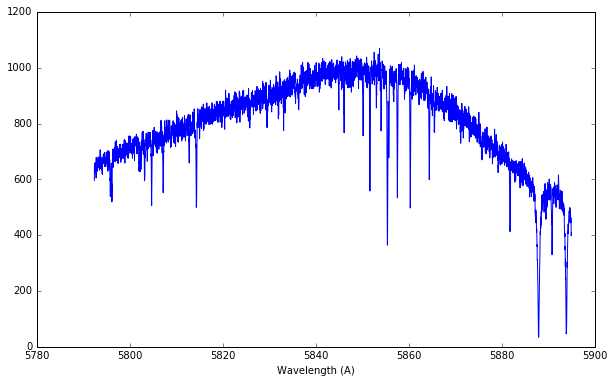

In [97]:
x = wave_values_r[10, 0:4016]
y = image_r[10, 0:4016]
plt.figure(figsize = (10,6))
plt.plot(x,y)
plt.xlabel('Wavelength (A)')

This looks almost like what we want! It seems we may have graphed too large of a wavelength range to pick out particular features. For an idea of what types of spectral features we hope to pick out, we can take a look at some sample graphs of this spectrum and attempt to recreate them ourselves.

![Example Spectrums](SampleGraphs.png)

These graphs use much smaller wavelength ranges than we just did. Let's try and adjust our own range to match some of these images. It would prudent to first determine the total scope of wavelengths represented in our spectrum. We may find that some of the example graphs are out of our range. We can determine the lowest and highest wavelengths represented by looking at the first value on the 0th line (top left corner) and the last value on the 15th line (bottom right corner):

In [98]:
print (wave_values_r[0, 0])
print (wave_values_r[15, 4020])

4976.64794645
6421.36429021


It looks like our range goes from 4976 Angstroms to 6421 Angstroms. So of the six example graphs, we can only attempt to replicate graphs 3 through 5. That's alright though, because we have included the two CCD's that complete the full wavelength spectrum available. We will open these and their wavelength solution counterparts now and check their dimensions:

In [99]:
spectrum_b = pf.open('bj122.97.fits')
wavelength_b = pf.open('keck_bwav.fits')
wave_values_b = wavelength_b[0].data
spectrum_b.info()

spectrum_i = pf.open('ij122.97.fits')
wavelength_i = pf.open('keck_iwav.fits')
wave_values_i = wavelength_i[0].data
spectrum_i.info()

Filename: bj122.97.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     722   (4021, 23)   float32   
Filename: ij122.97.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     722   (4021, 10)   float32   


It's good that we checked the dimensions of the two other CCD's since they have different total numbers of lines. With this information, we can now check the wavelength boundaries of the two CCD's.

In [100]:
print (wave_values_b[0, 0])
print (wave_values_b[22, 4020])

print (wave_values_i[0,0])
print (wave_values_i[9, 4020])

3642.93
4794.53
6543.15071655
7989.83665355


Alright, now we know the entire spectrum. As you may have noticed, the ends of the spectrums do not perfectly overlap with each other. This will not affect our ability to recreate the sample graphs.

It is time to recreate the first spectrum of the six shown. The first step is to examine the boundaries on the graph given. They appear to go from 3958 to 3978. Plugging in test values to wave_values_b will eventually reveal that the 3958 and 3978 Angstrom marks correspond closest to the 1772nd and 2946th pixels (respectively) on the seventh line.

In [101]:
print (wave_values_b[7, 1772])
print (wave_values_b[7, 2946])

3958.01
3978.0


Play around with new values in the above cell (keeping in mind the boundaries on the CCD) until you get a good idea of how the pixels and wavelengths correspond to each other. Once you feel you have it, you can save a lot of guesswork using this set of tables from the Keck Observatory website:

### HIRES blue chip (b):

Wavelength range (Ang) per order:

    order    min wavelength  max wavelength
********************************************
       0       3642.9314       3706.8240
       1       3680.7625       3745.3972
       2       3719.7527       3784.8733
       3       3759.0449       3825.1785
       4       3799.5925       3866.3210
       5       3840.8242       3908.3191
       6       3883.0046       3951.3738
       7       3926.1953       3995.2864
       8       3970.2517       4040.0691
       9       4015.3870       4086.0713
      10       4061.5300       4133.0503
      11       4108.7329       4181.1284
      12       4157.0581       4230.3276
      13       4206.5337       4280.7046
      14       4257.1963       4332.2949
      15       4309.0938       4385.1489
      16       4362.2773       4439.2959
      17       4416.7856       4494.8013
      18       4472.6772       4551.7104
      19       4530.0059       4610.0815
      20       4588.8154       4669.9697
      21       4649.1797       4731.4287
      22       4711.1470       4794.5278
      

### HIRES "Middle" or "iodine" chip (r)
      
Wavelength range (Ang) per order:

    order    min wavelength  max wavelength
********************************************
       0       4976.6479       5064.7810
       1       5047.7274       5137.1426
       2       5120.8688       5211.6012
       3       5196.1628       5288.2490
       4       5273.7059       5367.1835
       5       5353.6004       5448.5086
       6       5435.9548       5532.3342
       7       5520.8845       5618.7774
       8       5608.5123       5707.9627
       9       5698.9690       5800.0225
      10       5792.3939       5895.0982
      11       5888.9355       5993.3403
      12       5988.7527       6094.9099
      13       6092.0150       6199.9788
      14       6198.9040       6308.7312
      15       6309.6143       6421.3643
      

### HIRES Red chip (i)
      
Wavelength range (Ang) per order:

    order    min wavelength  max wavelength
********************************************
       0       6543.1507       6658.9463
       1       6666.6266       6784.5357
       2       6794.8600       6914.9490
       3       6928.1312       7050.4689
       4       7066.7430       7191.4008
       5       7211.0231       7338.0753
       6       7361.3265       7490.8502
       7       7518.0383       7650.1142
       8       7681.5775       7816.2897
       9       7852.4000       7989.8367

Now that we have our boundaries for the first graph, we can create our data arrays and plug in our values to see if we get a similar graph using our pixel choices. We will display the sample graph right below:

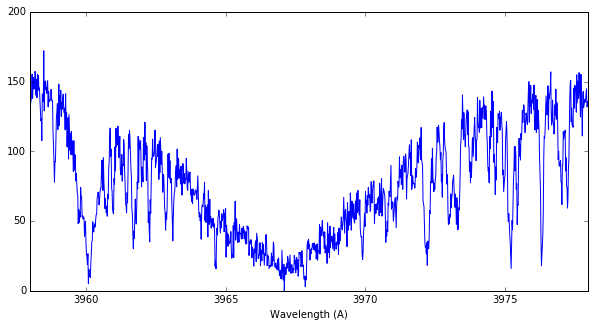

In [102]:
image_b = spectrum_b[0].data
image_i = spectrum_i[0].data

x = wave_values_b[7, 1772:2946]
y = image_b[7, 1772:2946]
plt.figure(figsize = (10,5))
plt.plot(x,y)
plt.axis([3958, 3978, 0, 200])
plt.xlabel('Wavelength (A)')

![Graph 1](Graph1.jpg)

Looks great! Now that you know how to find the proper boundaries, and how to use them in a graph, we can skip some steps replicating the rest of the graphs:

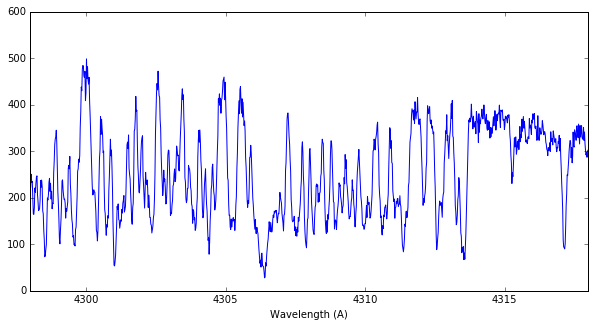

In [103]:
x = wave_values_b[14, 2100:3195]
y = image_b[14, 2100:3195]
plt.figure(figsize = (10,5))
plt.plot(x,y)
plt.axis([4298, 4318, 0, 600])
plt.xlabel('Wavelength (A)')

![Graph 2](Graph2.jpg)

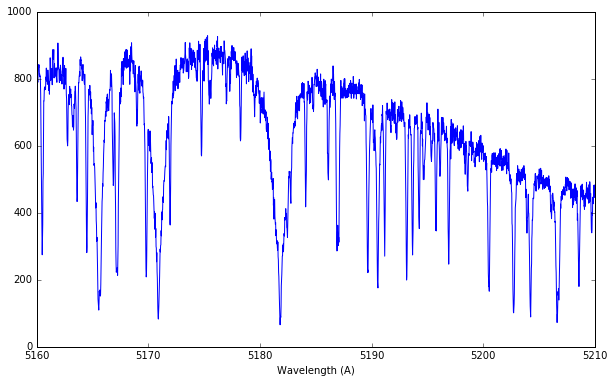

In [104]:
x = wave_values_r[2, 1654:3942]
y = image_r[2, 1654:3942]
plt.figure(figsize = (10,6))
plt.plot(x,y)
plt.axis([5160, 5210, 0 , 1000])
plt.xlabel('Wavelength (A)')

![](Graph3.jpg)

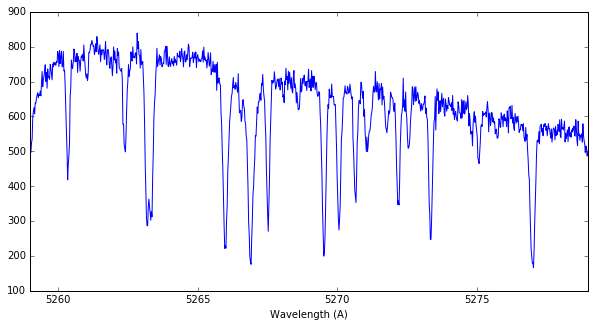

In [105]:
x = wave_values_r[3, 2664:3580]
y = image_r[2, 2664:3580]
plt.figure(figsize = (10, 5))
plt.plot(x,y)
plt.axis([5259, 5279, 100, 900])
plt.xlabel('Wavelength (A)')

![](Graph4.jpg)

Our first issue! These two graphs don't look alike. This confirms something that you may have started to suspect by looking very closely at the previous graphs: they are not the same star. 

The two graphs we just produced are different because the metallicity of the two stars are different. The similarity between two different Sun-like stars is still strong, however, so using a different star's spectral readings is still an adequate way of testing whether or not your own readings are correctly programmed.

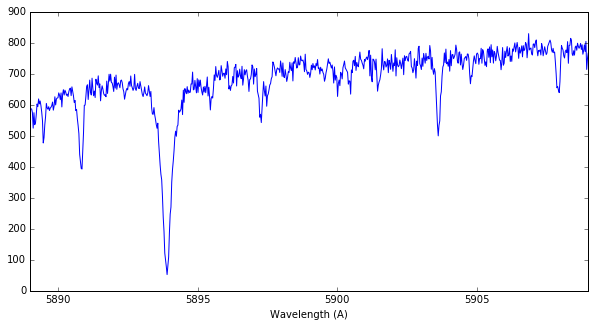

In [106]:
x = wave_values_r[11, 3:728]
y = image_r[11, 3:728]
plt.figure(figsize = (10,5))
plt.plot(x,y)
plt.axis([5889, 5909, 0, 900])
plt.xlabel('Wavelength (A)')

![](Graph5.jpg)

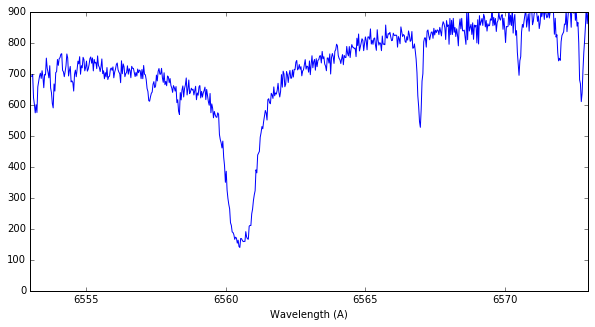

In [107]:
x = wave_values_i[0, 321:979]
y = image_i[0, 321:979]
plt.figure(figsize = (10,5))
plt.plot(x,y)
plt.axis([6553, 6573, 0, 900])
plt.xlabel('Wavelength (A)')

![](Graph6.jpg)

Great! Our graphs have turned out how we wanted them, and now with a few minor changes to the code in this program, you can make similar graphs for CCD's from other stars! You need to:

1.) Download new CCD's and move them to your notebook folder. (DON'T try and download new wavelength solutions, the ones attached should work for all CCD's within one pixel)

2.) Change the file names called in this program (If you haven't noticed yet, each CCD filename we used varies by the letter r, b, or i. That is why we added these tags to the variables, so that you wouldn't have to change them when getting new data).

Once that is done, you should be all set to analyze your own data! Good luck!